**NOTEBOOK 1: INTRODUCTION TO CONSTITUTIVE MODELLING IN ARTERIAL BIOMECHANICS**

Mobina Izadpanah (mobina.izadpanah@maastrichtuniversity.nl) and Alessandro Giudici (a.giudici@maastrichtuniversity.nl)

Hi everyone! Welcome to the Constitutive Modelling workshop!

In this first notebook, we're going to work with the Holzapfel-Gasser-Ogden (HGO) model. This model consists of the summed contributions of two parts: an isotropic part, representing the ground matrix, and an anisotropic part, representing two collagen fibre families. The HGO strain energy density function (SEDF) is given as  



$$
W_\text{hgo} = W_\text{matrix} + W_\text{collagen}
$$
where
$$
W_\text{matrix} = c (I_1 - 3)
$$

$$
W_\text{collagen} = \frac{k_1}{2k_2} \sum_{i=4,6} \exp(k_2 (I_i-1)^2) - 1 .
$$

In the equations above, $ c $ is a stress-like neo-Hookean parameter, $ k_1 $ is an fibre stress-like parameter, and $ k_2 $ is a fibre nonlinearity parameter. $I_1$ is the first principal invariant of the right Cauchy-Green tensor $\textbf{C}$, which is its trace, and $I_4$ and $I_6$ are invariants accounting for the two preferential fibre directions (equal to $\pm\alpha$ here).

In the schematic image below, you can see the two embedded collagen families with the orientations $\pm\alpha$.


<div style="text-align:center;">
  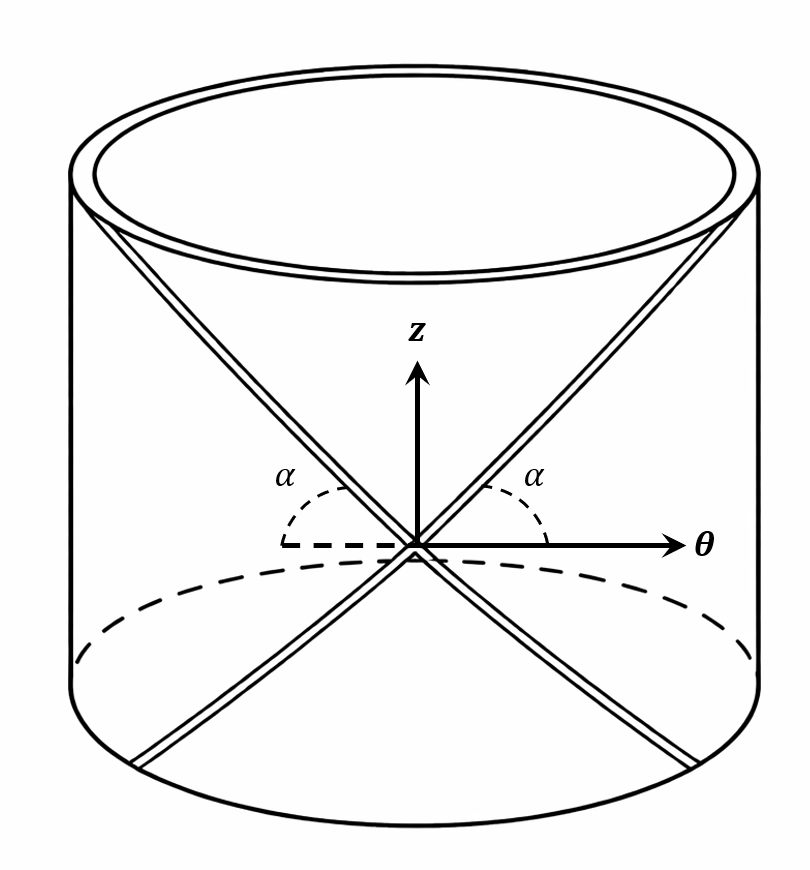
    <div style="font-size:90%; margin-top:6px;">
    <b>Figure 1.</b> A sketch of the thin-walled artery with two embedded collagen fibre families, inspired by Gasser et al., 2006.
  </div>
</div>

Given the SEDF $ W_\text{hgo} $, the Cauchy stress tensor is:




$$
\boldsymbol{\sigma} = -p\textbf{I} + 2 \textbf{F} \frac{\partial W_\text{hgo}}{\partial \textbf{C}} \textbf{F}^\text{T}
$$
Here is the Python function of the HGO model:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

Pa2mmHg = 1 / 133.32 # conversion of [Pa] to [mmHg]

def hgo_stress(lambda_t, lambda_z, c , k1, k2, alpha):

    """
    HGO circumferential (t), axial (z) and radial (r) stress function

    Parameters:
    ----------
    lambda_t: circumferential stretch (dimensionless)
    lambda_z: axial stretch (dimensionless)
    c: neo-Hookean parameter (Pa)
    k1: stress-like parameter for fibres (Pa)
    k2: nonlinearity parameter (dimensionless)
    alpha: fibre angle (radian)

    return:
    ----------
    sigmatt: circumferential Cauchy stress (Pa)
    sigmazz: axial Cauchy stress (Pa)
    sigmarr: radial Cauchy stress (Pa)

    """

    # Defining stretches
    lambda_t = np.asarray(lambda_t, dtype=np.float64)
    lambda_z = np.asarray(lambda_z, dtype=np.float64)

    # Fibre angles
    cos_a = np.cos(alpha)
    sin_a = np.sin(alpha)

    # Fibre invariant
    I4 = lambda_t**2 * cos_a**2 + lambda_z**2 * sin_a**2

    # Circumferential extra Cauchy stress
    # ECM (isotropic) contribution
    sigmatt_matrix = c * lambda_t**2

    # Collagen (fiber) contribution
    sigmatt_fibre = 2* 2.0 * k1 * lambda_t**2 * cos_a**2 * (I4 - 1) * np.exp(k2 * (I4-1)**2)

    sigmatt_total = sigmatt_matrix + sigmatt_fibre

    # Axial extra Cauchy stress
    # Matrix (isotropic) contribution
    sigmazz_matrix = c * lambda_z**2

    # Collagen (fiber) contribution
    sigmazz_fibre = 2 * 2 * k1 * lambda_z**2 * sin_a**2 * (I4 - 1) * np.exp(k2 * (I4-1)**2)

    sigmazz_total = sigmazz_matrix + sigmazz_fibre

    # Radial extra Cauchy stress
    # Matrix (isotropic) contribution
    sigmarr_matrix = c * lambda_t**(-2) * lambda_z**(-2)

    # Collagen (fiber) contribution
    sigmarr_fibre = 0

    sigmarr_total = sigmarr_matrix + sigmarr_fibre

    return { "sigmatt_total": sigmatt_total,
             "sigmatt_matrix":sigmatt_matrix,
             "sigmatt_fibre":sigmatt_fibre,
             "sigmazz_total":sigmazz_total,
             "sigmazz_matrix":sigmazz_matrix,
             "sigmazz_fibre":sigmazz_fibre,
             "sigmarr_total":sigmarr_total,
             "sigmarr_matrix":sigmarr_matrix,
             "sigmarr_fibre": sigmarr_fibre}

A very common experiment used to characterize the mechanical behaviour of arteries is planar biaxial testing. Samples retrieved from arteries are typically cut into square shapes and tested as shown in the image below. The biaxial stretches represent the physiological circumferential and axial loads to which the vessel wall is subjected





<table>
<tr>
  <td style="text-align:center; vertical-align:top;">
    <div style="position:relative; display:inline-block;">
      <span style="position:absolute; top:6px; left:8px;
                   font-weight:bold; font-size:14px;">(a)</span>
      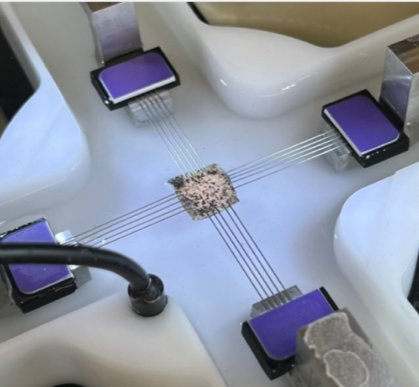
    </div>
  </td>

  <td style="text-align:center; vertical-align:top;">
    <div style="position:relative; display:inline-block;">
      <span style="position:absolute; top:6px; left:8px;
                   font-weight:bold; font-size:14px;">(b)</span>
      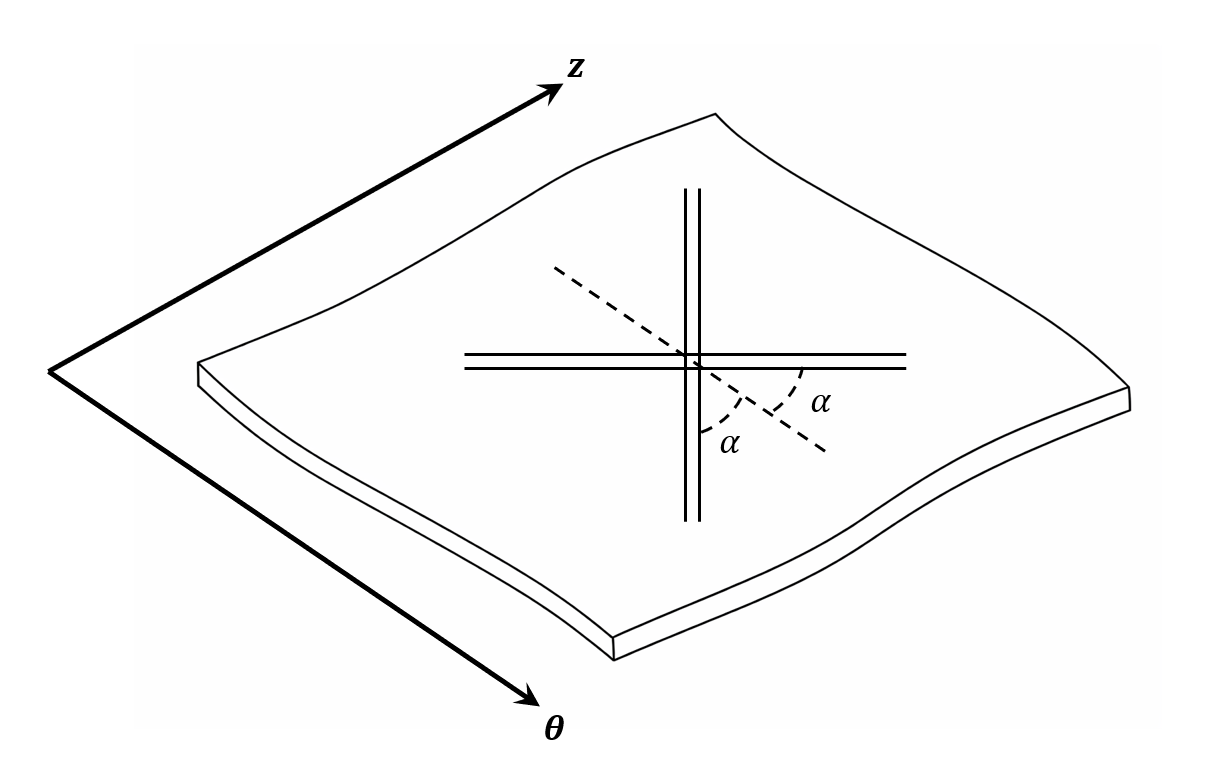
    </div>
  </td>
</tr>

<tr>
  <td colspan="2"
      style="text-align:center; font-size:90%; padding-top:6px;">
    <b>Figure 2.</b>
    (a) Biaxial testing of the lamb's carotid artery by our colleague Cindy van Loo.
    &nbsp;&nbsp;
    (b) A schematic representation of an arterial specimen, inspired by Gasser et al., 2006.
  </td>
</tr>
</table>




In this workshop, we aim to simulate a biaxial test with equi-biaxial stretches in the axial and circumferential directions. You can change the material parameters $c$, $k_1$, $k_2$, and $\alpha$ to see their effect on the mechanical behaviour of the matrix, collagen, and the total arterial wall.


Please keep in mind that you have to re-run the code below every time you make a change!

After each run, you'll see four plots. The first two are 3-dimensional plots showing how the circumferential and axial stresses change with the biaxial stretches. To make these trends easier to interpret, we also provide the same results in 2-dimensional plots.

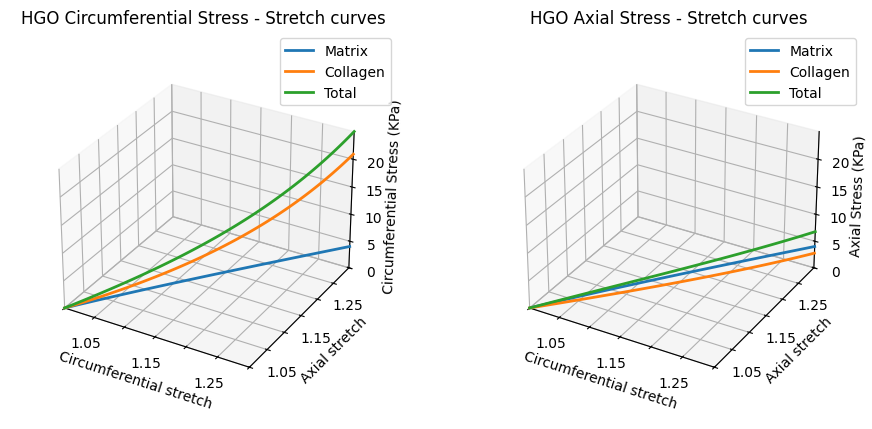

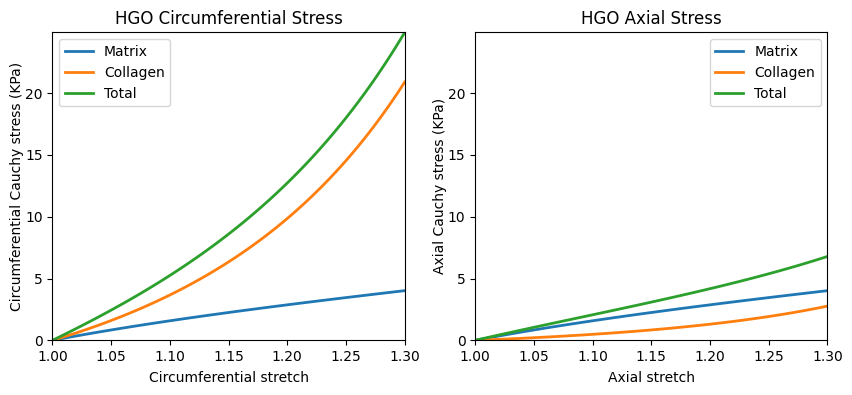

In [7]:
# Equi-biaxial stretches (lambda_t = lambda_z)
lambda_t_vec = np.linspace(1, 1.3, 100).reshape(-1 , 1)
lambda_z_vec = np.linspace(1, 1.3, 100).reshape(-1, 1)


# Material parameters
# You can adjust these parameters
#--------------------------------
c = 3e3 #neo-Hookean parameter (Pa)
k1 = 4e3 #stress-like parameter for fibres (Pa)
k2 = 0.5 #nonlinearity parameter (dimensionless)
alpha = np.deg2rad(20) #fibre angle (radian)
#--------------------------------

# Well done! You do not need to change anything else in the rest of the code!
stresses = hgo_stress(lambda_t_vec, lambda_z_vec, c, k1, k2, alpha)

sigmatt_matrix_trial = stresses["sigmatt_matrix"]
sigmatt_fibre_trial = stresses["sigmatt_fibre"]
sigmatt_total_trial = stresses["sigmatt_total"]

sigmazz_matrix_trial = stresses["sigmazz_matrix"]
sigmazz_fibre_trial = stresses["sigmazz_fibre"]
sigmazz_total_trial = stresses["sigmazz_total"]

sigmarr_matrix_trial = stresses["sigmarr_matrix"]
sigmarr_fibre_trial = stresses["sigmarr_fibre"]
sigmarr_total_trial = stresses["sigmarr_total"]

# Applying the lagrange multiplier (i.e., p = sigmarr)
sigmatt_matrix_trial = sigmatt_matrix_trial - sigmarr_matrix_trial
sigmatt_fibre_trial = sigmatt_fibre_trial - sigmarr_fibre_trial
sigmatt_total_trial = sigmatt_total_trial - sigmarr_total_trial

sigmazz_matrix_trial = sigmazz_matrix_trial - sigmarr_matrix_trial
sigmazz_fibre_trial = sigmazz_fibre_trial - sigmarr_fibre_trial
sigmazz_total_trial = sigmazz_total_trial - sigmarr_total_trial

sigmarr_matrix_trial = sigmarr_matrix_trial - sigmarr_matrix_trial
sigmarr_fibre_trial = sigmarr_fibre_trial - sigmarr_fibre_trial
sigmarr_total_trial = sigmarr_total_trial - sigmarr_total_trial

# Plotting the figures

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    subplot_kw={"projection": "3d"},
    figsize=(11, 8),
    #constrained_layout=True,
)


# Circumferential 3D plot
line1, = ax1.plot(lambda_t_vec, lambda_z_vec, sigmatt_matrix_trial/1000, label="Matrix", linewidth=2)
line2, = ax1.plot(lambda_t_vec, lambda_z_vec, sigmatt_fibre_trial/1000, label="Collagen",linewidth=2)
line3, = ax1.plot(lambda_t_vec, lambda_z_vec, sigmatt_total_trial/1000, label="Total",linewidth=2)

for label in ax1.get_xticklabels()[::2]:
    label.set_visible(False)

for label in ax1.get_yticklabels()[::2]:
    label.set_visible(False)


ax1.set_ylim(1.0, 1.3)
ax1.set_xlim(1.0, 1.3)
ax1.set_zlim(0, max(sigmatt_total_trial.max()/1000,sigmazz_total_trial.max()/1000))
ax1.set_xlabel("Circumferential stretch",labelpad=5)
ax1.set_ylabel("Axial stretch",labelpad=5)
ax1.set_zlabel("Circumferential Stress (KPa)",labelpad=0.1)
ax1.set_title("HGO Circumferential Stress - Stretch curves")
ax1.set_box_aspect(None, zoom=0.85)
ax1.legend()

# Axial 3D plot
line4, = ax2.plot(lambda_t_vec, lambda_z_vec, sigmazz_matrix_trial/1000, label="Matrix", linewidth=2)
line5, = ax2.plot(lambda_t_vec, lambda_z_vec, sigmazz_fibre_trial/1000, label="Collagen",linewidth=2)
line6, = ax2.plot(lambda_t_vec, lambda_z_vec, sigmazz_total_trial/1000, label="Total",linewidth=2)

for label in ax2.get_xticklabels()[::2]:
    label.set_visible(False)

for label in ax2.get_yticklabels()[::2]:
    label.set_visible(False)

ax2.set_ylim(1.0, 1.3)
ax2.set_xlim(1.0, 1.3)
ax2.set_zlim(0, max(sigmatt_total_trial.max()/1000,sigmazz_total_trial.max()/1000))
ax2.set_xlabel("Circumferential stretch",labelpad=5)
ax2.set_ylabel("Axial stretch",labelpad=5)
ax2.set_zlabel("Axial Stress (KPa)",labelpad=0.8)
ax2.set_title("HGO Axial Stress - Stretch curves")
ax2.set_box_aspect(None, zoom=0.85)
ax2.legend()


plt.show()


fig, (ax1, ax2) = plt.subplots(
    1,2,
    figsize=(10,4),
    #constrained_layout=True
)

# Circumferential 2D plot
ax1.plot(lambda_t_vec, sigmatt_matrix_trial/1000,label="Matrix", linewidth=2)
ax1.plot(lambda_t_vec, sigmatt_fibre_trial/1000,label="Collagen", linewidth=2)
ax1.plot(lambda_t_vec, sigmatt_total_trial/1000,label="Total", linewidth=2)

ax1.set_xlim(1,1.3)
ax1.set_ylim(0, max(sigmatt_total_trial.max()/1000,sigmazz_total_trial.max()/1000))
ax1.set_xlabel("Circumferential stretch",labelpad=5)
ax1.set_ylabel("Circumferential Cauchy stress (KPa)",labelpad=0.8)
ax1.set_title("HGO Circumferential Stress")
ax1.legend();

# Axial 2D plot
ax2.plot(lambda_t_vec, sigmazz_matrix_trial/1000,label="Matrix", linewidth=2)
ax2.plot(lambda_t_vec, sigmazz_fibre_trial/1000,label="Collagen", linewidth=2)
ax2.plot(lambda_t_vec, sigmazz_total_trial/1000,label="Total", linewidth=2)

ax2.set_xlim(1,1.3)
ax2.set_ylim(0, max(sigmatt_total_trial.max()/1000,sigmazz_total_trial.max()/1000))
ax2.set_xlabel("Axial stretch",labelpad=5)
ax2.set_ylabel("Axial Cauchy stress (KPa)",labelpad=0.8)
ax2.set_title("HGO Axial Stress")
ax2.legend();

Now, let's see the effect of parameter changes on pressure-diameter curves. Pressure-diameter data can be collected *in vivo* and is also a more closely representative of the arterial wall's physiological behaviour. Generally, arterial pressure-diameter curves have an S-shape, as given in Figure 3.

<div style="text-align:center;">
  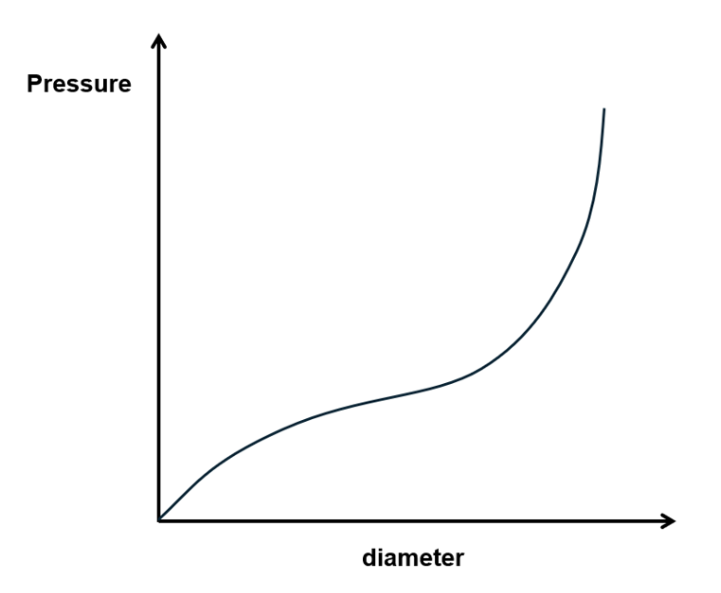
    <div style="font-size:90%; margin-top:6px;">
    <b>Figure 3.</b> A schematic pressure-diameter curve.
  </div>
</div>


In the next section, we simulate the pressurization of an artery. In the body, arteries are subjected to a physiological **axial stretch**, and to **blood pressure** (see Figure 4). We can replicate this condition by applying a fixed axial stretch in our code and varying the circumferential stretch to simulate the gradual inflation of the artery.  





<table>
<tr>
  <td style="text-align:center; vertical-align:top;">
    <div style="position:relative; display:inline-block;">
      <span style="position:absolute; top:6px; left:8px;
                   font-weight:bold; font-size:14px;">(a)</span>
      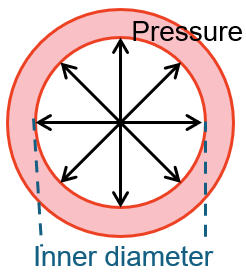
    </div>
  </td>
  <td style="text-align:center; vertical-align:top;">
    <div style="position:relative; display:inline-block;">
      <span style="position:absolute; top:6px; left:8px;
                   font-weight:bold; font-size:14px;">(b)</span>
      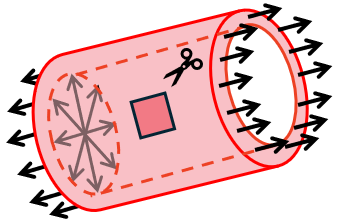
    </div>
  </td>
  </tr>
  <tr>
  <td colspan="2" style="text-align:center;">
    <div style="position:relative; display:inline-block;">
      <span style="position:absolute; top:6px; left:8px;
                   font-weight:bold; font-size:14px;">(c)</span>
      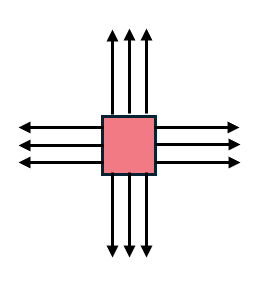
    </div>
  </td>
</tr>

<tr>
  <td colspan="3"
      style="text-align:center; font-size:90%; padding-top:6px;">
    <b>Figure 4.</b>
    (a) A schematic two-dimensional, cross-sectional view of the artery.
    <br><br>
    (b) A schematic representation of the physiological mechanical loads (pressure and axial stretch) applied to the artery, along with a schematic illustrating how the specimen is cut for biaxial testing.
    <br><br>
    (c) A schematic arterial specimen subjected to biaxial testing.
  </td>
</tr>
</table>







Let's change the HGO parameters and see how the pressure-diameter curves change compared to the actual experimental results of a lamb's carotid artery (collected experimentally in our Maastricht lab by Cindy van Loo). For now, we have already fixed the axial stretch at the estimated value of 1.4: i.e., a 40% elongation of the carotid artery with respect to its excised load-free state.

We recommend you put the values of parameters to 0 one by one to see the effects of each parameter.

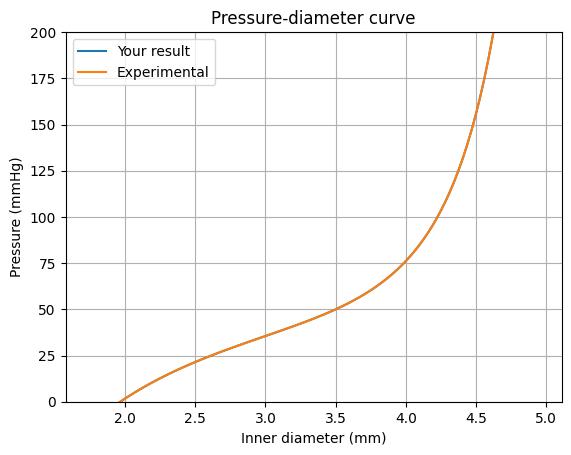

In [4]:
# Pressure-diameter curves
# Biaxial stretches with a fixed axial stretch
lambda_t_vec = np.linspace(0.8, 1.6, 100).reshape(-1 , 1)
lambda_z_vec = 1.4


# Material parameters
# You can adjust these parameters
#--------------------------------
c = 12.8e3 #neo-Hookean parameter (Pa)
k1 = 1.6e3 #stress-like parameter for fibres (Pa)
k2 = 1.3 #nonlinearity parameter (dimensionless)
alpha = np.deg2rad(25) #fibre angle (radian)
#--------------------------------

# These are the experimental-based parameters. Please don't change them :)

c_exp = 12.8e3 #neo-Hookean parameter (Pa)
k1_exp  = 1.6e3 #stress-like parameter for fibres (Pa)
k2_exp  = 1.3 #nonlinearity parameter (dimensionless)
alpha_exp  = np.deg2rad(25) #fibre angle (radian)

# Sample dimensions
R_m = 1.7e-3 # undeformed mean radius artery (m)
H = 1.1e-3 # undeformed wall thickness (m)


stresses = hgo_stress(lambda_t_vec, lambda_z_vec, c, k1, k2, alpha)
stresses_exp = hgo_stress(lambda_t_vec, lambda_z_vec, c_exp , k1_exp , k2_exp , alpha_exp )


# Changes in arterial geometry with pressurisation
h = H / (lambda_t_vec * lambda_z_vec) # deformed wall thickness
r_m = R_m * lambda_t_vec # deformed mid-wall radius
r_i = r_m - h / 2 # deformed luminal (inner) radius

# Pressure calculations
pressure = (stresses["sigmatt_total"] - stresses["sigmarr_total"]) * h / r_m
pressure_exp = (stresses_exp["sigmatt_total"] - stresses_exp["sigmarr_total"]) * h / r_m


plt.figure()
plt.plot(2 * r_i * 1000, pressure * Pa2mmHg, label="Your result")
plt.plot(2 * r_i * 1000, pressure_exp * Pa2mmHg, label="Experimental")

plt.xlabel("Inner diameter (mm)")
plt.ylabel("Pressure (mmHg)")
plt.title("Pressure-diameter curve")
plt.ylim(0,200)
plt.grid(True)
plt.legend()
plt.show()



Now, let's specifically discuss the *in vivo* axial stretch! It is important to measure and/or determine this *in vivo* stretch for simulations that accurate arterial physiology.

Besides experimentally measuring the axial retraction of an artery upon excision from the body, there are two ways to estimate the *in vivo* axial stretch, both based on the observation that, at this axial stretch, the reduced axial force of arteries is realtively constant with pressure. In the first method, one just varies the axial stretch to find the one that yields the flattest axial reduced axial force-pressure curve. We are going to try this first; we have fixed the material parameters, and you can now try different axial stretches and visualise the resulting reduced axial force-pressure curve.


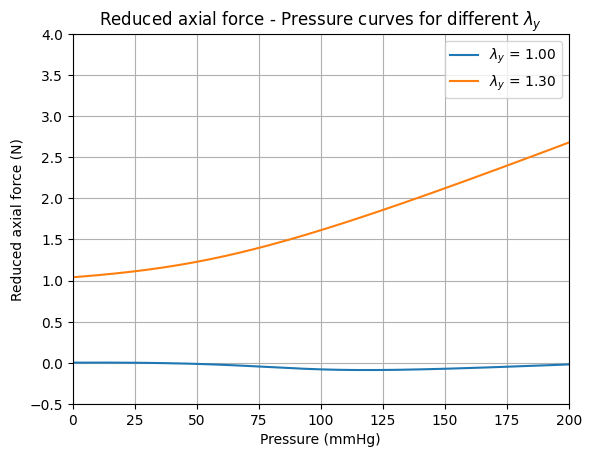

In [5]:
# The circumferential stretch changing from 1 to 1.3 for each test (do not change)
lambda_t_vec = np.linspace(0.8, 1.6, 200)

# First, just run the code as it is. Then, come back here!
# Now, add numbers in between to find the stretch providing the flattest pressure-force relationship.
lambda_z_values = [1.0, 1.3]


# Material parameters
# These parameters were calculated by Cindy
#--------------------------------
c_h = 53.28e3 #neo-Hookean parameter (Pa)
k1_h = 3.38e3 #stress-like parameter for fibres (Pa)
k2_h = 16.93 #nonlinearity parameter (dimensionless)
alpha_h = np.deg2rad(48.01) #fibre angle (radian)
# Sample dimensions
R_m = 3.21e-3 # mean radius of human carotid artery (m)
H = 1.16e-3 # (m)
#--------------------------------

# Force-pressure curves
# Solving the pressure - reduced axial force relationship for all the input axial stretches
plt.figure()
for ly in lambda_z_values:
    # Calculating the wall stresses
    stresses_FixedAxial = hgo_stress(lambda_t_vec, ly, c_h, k1_h, k2_h, alpha_h)

    # Changes in arterial geometry with pressurisation
    r_m = R_m * lambda_t_vec # deformed mid-wall radius
    h = H / (lambda_t_vec * ly) # deformed wall thickness

    force = np.pi * r_m * h * (2 * stresses_FixedAxial["sigmazz_total"] - stresses_FixedAxial["sigmatt_total"] - stresses_FixedAxial["sigmarr_total"])
    pressure = (stresses_FixedAxial["sigmatt_total"] - stresses_FixedAxial["sigmarr_total"]) * h / r_m
    plt.plot(pressure * Pa2mmHg, force , label=f"$λ_y$ = {ly:.2f}")

plt.xlabel("Pressure (mmHg)")
plt.ylabel("Reduced axial force (N)")
plt.title("Reduced axial force - Pressure curves for different $λ_y$")
plt.xlim(0,200)
plt.ylim(-0.5,4)
plt.grid(True)
plt.legend()
plt.show()



In the second approach, pressure values are fixed whilst the axial stretch is varied. By simulating the axial stretching of the artery for different values of pressure, the intersection of reduced axial force-axial stretch curves yields the *in vivo* axial stretch.

The axial stretch value at intersection point should closely match the axial stretch that yielded the flattest reduced axial force-pressure relationship in the graph above.


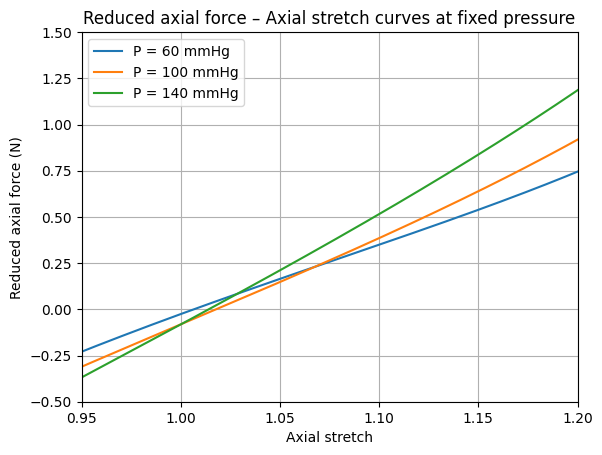

In [6]:
# Now, let's see the force-axial stretch curves, which are also a way to calculate the in-vivo axial stretch.
# Fixed pressure values are here. You can add more values to add another curve

pressure_values = [60, 100, 140] # Pressure in mmHg



def pressure_residuals(x, ly, p_target, hgo_params):
    lx = float(x[0])
    stresses = hgo_stress(lx, ly, hgo_params[0] , hgo_params[1], hgo_params[2], hgo_params[3])
    r_m = R_m * lx
    h = H / (lx * ly)
    p_model = (stresses["sigmatt_total"] - stresses["sigmarr_total"]) * h  / r_m * Pa2mmHg

    return np.array([p_model - p_target])

lambda_z_range = np.linspace(0.9, 1.4, 200)

# storage: lx[p_index, ly_index]
lx_sol = np.zeros((len(pressure_values), len(lambda_z_range)))

lx_guess = np.array([1.0])
lb = np.array([0.5]) # lower boundary
ub = np.array([1.5]) # upper boundary

for ip, p in enumerate(pressure_values):

    for iy, ly in enumerate(lambda_z_range):

        res = least_squares(
            pressure_residuals,
            x0=lx_guess,
            bounds = (lb, ub),
            args = (ly, p, [c_h, k1_h, k2_h, alpha_h])
        )
        lx_sol[ip, iy] = res.x[0]
        lx_guess= res.x

plt.figure()

for ip, p in enumerate(pressure_values):
    stresses_at_P = hgo_stress(lx_sol[ip,:], lambda_z_range, c_h, k1_h, k2_h, alpha_h)
    rm_at_P = R_m * lx_sol[ip,:]
    h_at_P = H / (lx_sol[ip,:] * lambda_z_range)
    force_at_P = np.pi * rm_at_P * h_at_P * (2 * stresses_at_P["sigmazz_total"] - stresses_at_P["sigmatt_total"] - stresses_at_P["sigmarr_total"])
    plt.plot(lambda_z_range, force_at_P, label=f"P = {p} mmHg")
plt.xlim([0.95,1.2])
plt.ylim([-0.5,1.5])
plt.xlabel("Axial stretch")
plt.ylabel("Reduced axial force (N)")
plt.title("Reduced axial force – Axial stretch curves at fixed pressure")
plt.grid(True)
plt.legend()
plt.show()



References:

Gasser, T. C., Ogden, R. W., & Holzapfel, G. A. (2006). Hyperelastic modelling of arterial layers with distributed collagen fibre orientations. Journal of the Royal Society, Interface, 3(6), 15–35. https://doi.org/10.1098/rsif.2005.0073